In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split as TTS,  GridSearchCV  
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB as NB

import nltk
from nltk.corpus import stopwords, sentiwordnet, wordnet
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import spacy

from typing import List
from pprint import pprint


import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim

import tqdm

%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore")


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# EDA
### PREPROCESSING

In [5]:
lotr = pd.read_csv("lotr_scripts.csv")
lotr.head()

,Unnamed: 0,char,dialog,movie
0,0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King
1,1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King
2,2,DEAGOL,Arrghh!,The Return of the King
3,3,SMEAGOL,Deagol!,The Return of the King
4,4,SMEAGOL,Deagol!,The Return of the King


In [6]:
lotr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2390 non-null   int64 
 1   char        2390 non-null   object
 2   dialog      2389 non-null   object
 3   movie       2390 non-null   object
dtypes: int64(1), object(3)
memory usage: 74.8+ KB


In [7]:
# Spotting inconcistencies with naming
lotr.char.unique()

array(['DEAGOL', 'SMEAGOL', '(GOLLUM', 'FRODO', 'MERRY', 'GIMLI',
       'GOLLUM', 'SAM', 'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE',
       'BILBO', 'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIL', 'ELROND',
       'GRIMA', 'FRODO VOICE OVER', 'WITCH KING', 'EOWYN', 'FARAMIR',
       'ORC', '\xa0GANDALF', 'SOLDIERS ON GATE', 'GOTHMOG', 'GENERAL',
       'CAPTAIN', 'SOLDIER', 'MOUTH OF SAURON', 'EOMER', 'ARMY', 'BOSON',
       'MERCENARY', 'EOWYN/MERRY', 'DENETHOR', 'ROHIRRIM',
       'GALADRIEL VOICEOVER', 'LEGOLAS', 'GALADRIEL', 'KING OF THE DEAD',
       'GRIMBOLD', 'IROLAS', 'ORCS', 'GAMLING', 'MADRIL', 'DAMROD',
       'SOLDIERS', 'SOLDIERS IN MINAS TIRITH', 'GANDALF VOICEOVER',
       'SOLDIER 1', 'SOLDIER 2', 'WOMAN', 'HALDIR', 'SAM VOICEOVER',
       'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'ELROND VOICEOVER',
       'ARWEN VOICEOVER', 'ARAGORN ', 'HAMA', 'SHARKU', 'PEOPLE', 'LADY',
       'FREDA', 'MORWEN', 'EYE OF SAURON', 'ROHAN STABLEMAN', 'GORBAG',
       'ARGORN', 'GA

In [8]:
flaws = list(["(GOLLUM", "GALADRIL", "FRODO VOICE OVER", "\xa0GANDALF", "MOUTH OF SAURON", "GALADRIEL VOICEOVER", "GANDALF VOICEOVER", 
         "SAM VOICEOVER", "ELROND VOICEOVER", "ARWEN VOICEOVER", "ARAGORN ", "ARGORN", "GANDALF VOICE OVER", "SARUMAN VOICE OVER", 
         "SARUMAN VOICE OVER ", "URUK-HAI" "FRODO ", "GALADRIEL VOICE-OVER", "SAURON VOICE", "SAM ", "FRODO VOICE", 
         "GALADRIEL VOICE OVER", "SARUMAN VOICEOVER", "BILBO VOICEOVER", "GATEKEEPR", "GAN DALF"])

correct = list(["GOLLUM", "GALADRIEL", "FRODO", "GANDALF","SAURON", "GALADRIEL", "GANDALF", "SAM", "ELROND", "ARWEN", "ARAGORN", "ARAGORN", 
                "GANDALF", "SARUMAN", "SARUMAN", "URUK HAI", "FRODO", "GALADRIEL", "SAURON", "SAM", "FRODO", "GALADRIEL", "SARUMAN", 
                "BILBO", "GATEKEEPER", "GANDALF"])

for i in range(len(flaws)):
    lotr.loc[lotr["char"] == flaws[i], "char"] = correct[i]
lotr.char.unique()


array(['DEAGOL', 'SMEAGOL', 'GOLLUM', 'FRODO', 'MERRY', 'GIMLI', 'SAM',
       'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE', 'BILBO',
       'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIEL', 'ELROND', 'GRIMA',
       'WITCH KING', 'EOWYN', 'FARAMIR', 'ORC', 'SOLDIERS ON GATE',
       'GOTHMOG', 'GENERAL', 'CAPTAIN', 'SOLDIER', 'SAURON', 'EOMER',
       'ARMY', 'BOSON', 'MERCENARY', 'EOWYN/MERRY', 'DENETHOR',
       'ROHIRRIM', 'LEGOLAS', 'KING OF THE DEAD', 'GRIMBOLD', 'IROLAS',
       'ORCS', 'GAMLING', 'MADRIL', 'DAMROD', 'SOLDIERS',
       'SOLDIERS IN MINAS TIRITH', 'SOLDIER 1', 'SOLDIER 2', 'WOMAN',
       'HALDIR', 'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'HAMA', 'SHARKU',
       'PEOPLE', 'LADY', 'FREDA', 'MORWEN', 'EYE OF SAURON',
       'ROHAN STABLEMAN', 'GORBAG', 'BOROMIR ', 'UGLUK', 'SHAGRAT',
       'FRODO ', 'URUK-HAI', 'SNAGA', 'GRISHNAKH', 'MERRY and PIPPIN',
       'WILDMAN', 'STRIDER', 'EOTHAIN', 'ROHAN HORSEMAN', 'FARMER MAGGOT',
       'WHITE WIZARD', 'MERRY AND P

In [9]:
lotr = lotr.dropna(axis=0)
lotr = lotr.drop(["Unnamed: 0", "movie"], axis=1)
lotr.head()

,char,dialog
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag..."
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!"
2,DEAGOL,Arrghh!
3,SMEAGOL,Deagol!
4,SMEAGOL,Deagol!


In [10]:

lotr_train, lotr_test = TTS(lotr, test_size=0.3, random_state=42)
lotr_train.reset_index(drop=True, inplace=True)
lotr_test.reset_index(drop=True, inplace=True)

### Initial EDA

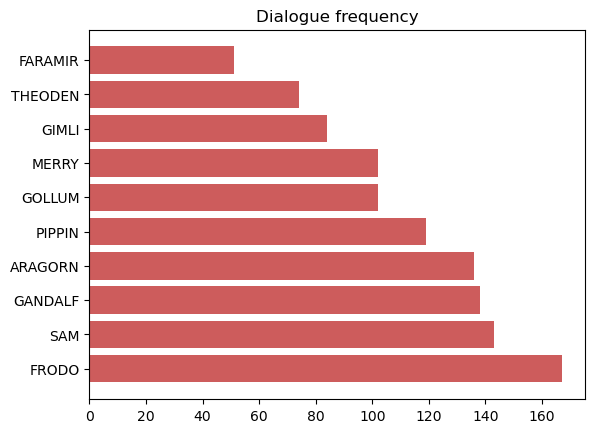

In [11]:
# Plotting dialouge frequnecy
char_freq = lotr_train.groupby("char").size().reset_index(name="freq")
char_freq = char_freq.sort_values(by="freq",ascending=False)
plt.barh(char_freq.char[:10], char_freq.freq[:10], color="indianred")
plt.title("Dialogue frequency")
plt.show()


### SIMPLE FEATURE ENGENERING

In [12]:
stopwords_set = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

def simple_features(data: pd.DataFrame):
    # dialog lengths
    data["word_len"] = data.dialog.apply(lambda x: len(x.split()))
    data["character_len"] = data.dialog.apply(lambda x: len(x))
    # Stopword count
    data["stopword_count"] = data.dialog.apply(lambda x: sum(1 for word in x.split() if word.lower() in stopwords_set))
    # Word frequency by POS Tag
    data['verb_count'] = data['dialog'].apply(count_verbs)
    data['adj_count'] = data['dialog'].apply(count_adjectives)
    data['propn_count'] = data['dialog'].apply(count_proper_noun)
    # Uniqe word counter
    data['uinque_words'] = data['dialog'].apply(unique_words)

    return data

def count_verbs(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "VERB")

def count_adjectives(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "ADJ")

def count_proper_noun(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "PROPN")

def unique_words(text):
    return len(set(text.split()))

lotr_train = simple_features(lotr_train)
lotr_test = simple_features(lotr_test)

# Ideeas for more #################
# avg. word length
# unique word ratio

C:\Users\marcu\AppData\Local\Temp\ipykernel_58936\3390235860.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


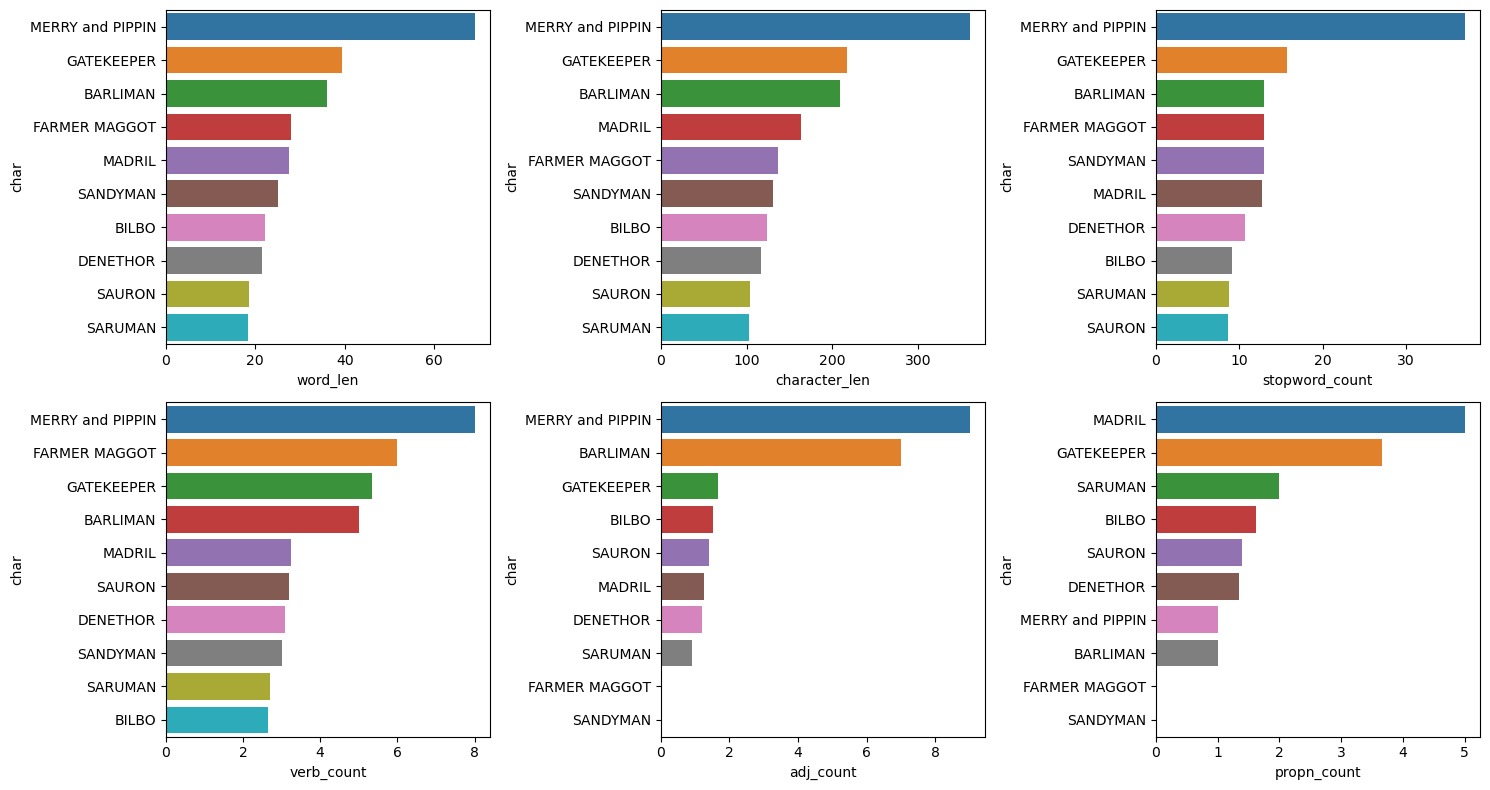

In [13]:
# Plotting dialouge frequnecy
char_var = lotr_train.groupby("char")[["word_len", "character_len", "stopword_count", "verb_count", "adj_count", "propn_count"]].mean().reset_index()
#char_var = char_var.sort_values(by="freq",ascending=False)

plt.figure(figsize = (15, 8))
plt.tight_layout()
plt.subplot(2, 3, 1)
char_var = char_var.sort_values(by="word_len", ascending=False)[:10]
sns.barplot(x=char_var.word_len, y=char_var.char)
plt.subplot(2, 3, 2)
char_var = char_var.sort_values(by="character_len", ascending=False)[:10]
sns.barplot(x=char_var.character_len, y=char_var.char)
plt.subplot(2, 3, 3)
char_var = char_var.sort_values(by="stopword_count", ascending=False)[:10]
sns.barplot(x=char_var.stopword_count, y=char_var.char)
plt.subplot(2, 3, 4)
char_var = char_var.sort_values(by="verb_count", ascending=False)[:10]
sns.barplot(x=char_var.verb_count, y=char_var.char)
plt.subplot(2, 3, 5)
char_var = char_var.sort_values(by="adj_count", ascending=False)[:10]
sns.barplot(x=char_var.adj_count, y=char_var.char)
plt.subplot(2, 3, 6)
char_var = char_var.sort_values(by="propn_count", ascending=False)[:10]
sns.barplot(x=char_var.propn_count, y=char_var.char)
plt.tight_layout()
plt.show()


### SENTIMENT ANALYSIS

In [14]:
# Dialog sentiment

def word_sentiment_score(word: str) -> float:
    synsets = list(sentiwordnet.senti_synsets(word))
    if synsets:
        sentiment = synsets[0]
        return sentiment.pos_score() - sentiment.neg_score()
    else:
        return 0.0  

def sentence_sentiment(sentence):
    sent = nlp(sentence)
    sent_sentiment = sum(word_sentiment_score(token.text) for token in sent)
    return sent_sentiment

def dialog_sentiment(data):
    data['dialog_sentiment'] = data['dialog'].apply(sentence_sentiment)
    return data

lotr_train = dialog_sentiment(lotr_train)
lotr_test = dialog_sentiment(lotr_test)

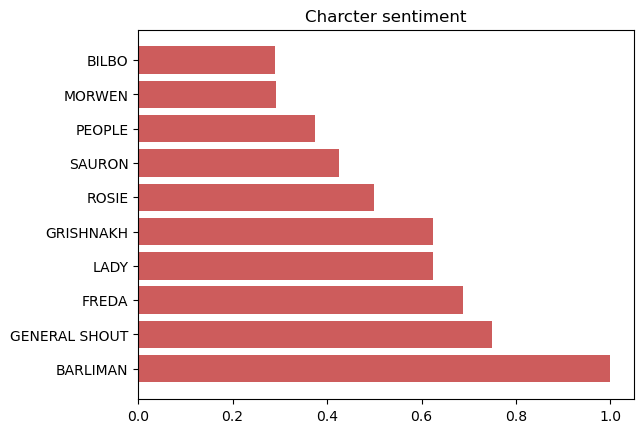

In [15]:
# Plotting dialouge frequnecy
char_sent = lotr_train.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
plt.barh(char_sent.char[:10], char_sent.dialog_sentiment[:10], color="indianred")
plt.title("Charcter sentiment")
plt.show()

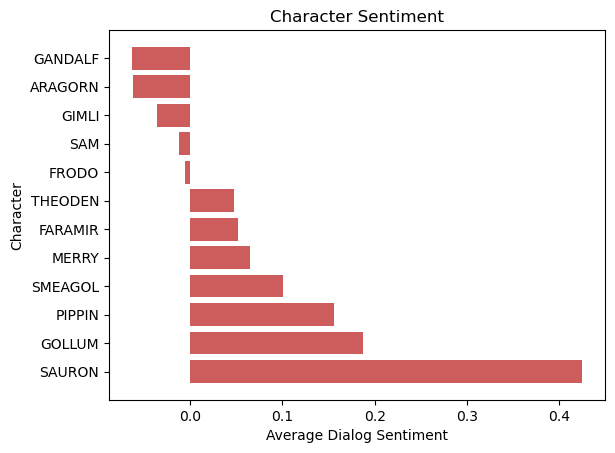

In [16]:
imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "SAURON", "ARAGORN", "SMEAGOL"]
# Plotting dialouge frequnecy
char_sent = lotr_train.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
char_sent_filtered = char_sent[char_sent['char'].isin(imp_char)]
plt.barh(char_sent_filtered['char'], char_sent_filtered['dialog_sentiment'], color="indianred")
plt.title("Character Sentiment")
plt.xlabel("Average Dialog Sentiment")
plt.ylabel("Character")
plt.show()

### LDA - Topic Analysis

In [17]:
# Topic modelling using LDA

stemmer = SnowballStemmer("english")


def stem(text):
    return stemmer.stem(text)

def preprocess_for_topic(document: str) -> List[str]:

    #tokenized = nlp(document)

    preprocessed = []
    for token in gensim.utils.simple_preprocess(document, min_len=4):
        if token not in stopwords_set: #and len(token) > 3:
            preprocessed.append(stem(token.lower()))
    return preprocessed


def create_bow_corp(data):
    preprocessed = []
    [preprocessed.append(preprocess_for_topic(dialog)) for dialog in data.dialog]
    dic = corpora.Dictionary(preprocessed)
    bow_corpus = [dic.doc2bow(doc) for doc in preprocessed]
    return preprocessed, dic, bow_corpus

preprocessed_train, dic_train, bow_corpus_train = create_bow_corp(lotr_train)
preprocessed_test, dic_test, bow_corpus_test = create_bow_corp(lotr_test)


lda_model = gensim.models.LdaMulticore(bow_corpus_train, num_topics = 3, id2word = dic_train, passes = 10, workers = 2, random_state=42)
lda_model.show_topics()

[(0,
  '0.010*"gondor" + 0.008*"aragorn" + 0.007*"good" + 0.007*"nice" + 0.007*"leav" + 0.007*"tree" + 0.006*"move" + 0.006*"king" + 0.006*"want" + 0.006*"gollum"'),
 (1,
  '0.027*"come" + 0.013*"master" + 0.010*"lord" + 0.009*"would" + 0.008*"must" + 0.008*"take" + 0.007*"precious" + 0.007*"king" + 0.006*"never" + 0.006*"go"'),
 (2,
  '0.028*"frodo" + 0.013*"gandalf" + 0.011*"merri" + 0.011*"know" + 0.009*"back" + 0.009*"come" + 0.009*"look" + 0.009*"ring" + 0.008*"cannot" + 0.008*"smeagol"')]

In [18]:
# Extract top contributing words for each topic
top_words_per_topic = []
for topic_id in range(lda_model.num_topics):
    topic_words = lda_model.show_topic(topic_id, topn=5)
    top_words = [word for word, _ in topic_words]
    top_words_per_topic.append(top_words)


for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: gondor, aragorn, good, nice, leav
Topic 1: come, master, lord, would, must
Topic 2: frodo, gandalf, merri, know, back


In [19]:
# Classifying the dialogs to their respective topics
predictions = lda_model[bow_corpus_train]
topic_list = []

for i, pred in enumerate(predictions[:5]):
    max_prob_topic = max(pred, key=lambda x: x[1])
    topic_list.append(max_prob_topic)
    topic_num, prob = max_prob_topic
    topic_keywords = ", ".join([word for word, _ in lda_model.show_topic(topic_num)])
    print(f"Review {i}:")
    print(f"Review body: {lotr_train.dialog[i]}")
    print(f"Predicted Topic: {topic_num}, Confidence: {prob:.4f}")

Review 0:
Review body: Grond, Grond, Grond, Grond!  
Predicted Topic: 0, Confidence: 0.8666
Review 1:
Review body: Smeagol?  
Predicted Topic: 2, Confidence: 0.6630
Review 2:
Review body: Look!The gate.It's opening!I can see a way down. 
Predicted Topic: 2, Confidence: 0.6578
Review 3:
Review body: Well, that's good news. 
Predicted Topic: 2, Confidence: 0.8119
Review 4:
Review body:     Frodo. 
Predicted Topic: 2, Confidence: 0.6614


In [20]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_train, dictionary=dic_train, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [21]:

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 3
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Validation sets
num_of_docs = len(bow_corpus_train)
corpus_sets = [gensim.utils.ClippedCorpus(bow_corpus_train, int(num_of_docs*0.75)), 
               bow_corpus_train]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dic_train, 
                                                  k=k)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Coherence'].append(cv)
                    
            pbar.update(1)
    pd.DataFrame(model_results)
    pbar.close()

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [08:43<00:00, 32.74s/it]


In [22]:
# Her må du plotte et diagram elns
model_res = pd.DataFrame(model_results)
model_res

,Validation_Set,Topics,Coherence
0,75% Corpus,3,0.393585
1,75% Corpus,4,0.450791
2,75% Corpus,5,0.441371
3,75% Corpus,6,0.450144
4,75% Corpus,7,0.451240
5,75% Corpus,8,0.445095
6,75% Corpus,9,0.422648
7,75% Corpus,10,0.463971
8,100% Corpus,3,0.394924
9,100% Corpus,4,0.424438


In [23]:
lda_model_optimized = gensim.models.LdaMulticore(bow_corpus_train, num_topics = 8, id2word = dic_train, passes = 10, 
                                                 chunksize=100, random_state=42)

# Extract top contributing words for each topic
top_words_per_topic = []
for topic_id in range(lda_model_optimized.num_topics):
    topic_words = lda_model_optimized.show_topic(topic_id, topn=5)
    top_words = [word for word, _ in topic_words]
    top_words_per_topic.append(top_words)


for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: tree, go, move, aragorn, care
Topic 1: would, think, precious, lord, gondor
Topic 2: come, smeagol, look, alway, saruman
Topic 3: master, must, need, ring, take
Topic 4: back, good, hurri, death, want
Topic 5: merri, kill, mordor, sauron, never
Topic 6: gandalf, quick, helm, victori, deep
Topic 7: frodo, leav, time, ring, hobbit


In [24]:

def topic_predictions(bow_data, data):
    predictions = lda_model_optimized[bow_data]
    data["topic"] = [max(pred, key=lambda x: x[1])[0] for pred in predictions]
    return data

lotr_train = topic_predictions(bow_corpus_train, lotr_train)
lotr_test = topic_predictions(bow_corpus_test, lotr_test)

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_optimized, bow_corpus_train, dictionary=lda_model_optimized.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.010123 -0.143812       1        1  14.126524
3      0.017028 -0.096477       2        1  13.112929
2      0.117028 -0.085649       3        1  13.065899
5      0.099986  0.153841       4        1  12.882501
0     -0.025334  0.069902       5        1  12.494875
1      0.008996  0.033303       6        1  12.212492
4     -0.232182  0.021010       7        1  11.898348
6      0.024602  0.047882       8        1  10.206431, topic_info=        Term        Freq       Total Category  logprob  loglift
72      come  103.000000  103.000000  Default  30.0000  30.0000
8      frodo   78.000000   78.000000  Default  29.0000  29.0000
200     leav   27.000000   27.000000  Default  28.0000  28.0000
1    smeagol   26.000000   26.000000  Default  27.0000  27.0000
23    master   34.000000   34.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
335     hand    4.728474   13.459798   Topic8  -5.0430   1.2360
238   strang    3.794167    9.568331   Topic8  -5.2632   1.3572
3       look    4.408937   28.051215   Topic8  -5.1130   0.4318
319     king    4.051768   28.208806   Topic8  -5.1975   0.3417
976    blood    3.717205    9.647414   Topic8  -5.2837   1.3284

[483 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1403      6  0.712125  aaaaaaaaa
1420      4  0.852919        abl
188       4  0.838965     across
998       4  0.817262       aiya
215       1  0.616213       alon
...     ...       ...        ...
106       5  0.089749      would
106       6  0.538491      would
106       7  0.089749      would
106       8  0.022437      would
179       7  0.866742      young

[840 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 3, 6, 1, 2, 5, 7])

### NRC Sentiment library for more emotions.

In [26]:
file_path = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt' # path to downloaded lexicon file

def emotion_lexicon(file_path):
    lexicon_emotion = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            word, emotion, value = line.strip().split('\t')
            if int(value) == 1:
                if word not in lexicon_emotion:
                    lexicon_emotion[word] = []
                lexicon_emotion[word].append(emotion) 
    return lexicon_emotion   

lexicon_emotion  = emotion_lexicon(file_path)

def emotion_counter(data):
    emotion_list = []

    for dialog in data.dialog:
        token_text = word_tokenize(dialog) # tokenize the text

        cleaned_text = [word for word in token_text if word not in stopwords_set] # remove stopwords
        emotion_counters = {emotion: 0 for emotions in lexicon_emotion.values() for emotion in emotions}
        for token in cleaned_text: # check every word in text
            if token in lexicon_emotion:
                token_emotions = lexicon_emotion[token]
                for emotion in token_emotions:
                    emotion_counters[emotion] += 1 # increase emotion values if the word in text is found in lexicon dictionary

        emotion_list.append(emotion_counters)
    emotions_df = pd.DataFrame(emotion_list)
    
    data = pd.concat([data, emotions_df], axis=1)
    return data, emotions_df

lotr_train, emotions_df = emotion_counter(lotr_train)
lotr_test, emotions_test_df = emotion_counter(lotr_test)

emotions_df


,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1667,0,1,2,1,2,0,0,1,0,0
1668,1,0,0,0,0,0,1,0,1,1
1669,0,0,0,0,0,0,0,0,0,0
1670,0,0,0,0,0,0,0,0,0,0


In [27]:
nan_count = lotr_train['dialog'].isna().sum()
nan_count

0

In [28]:
len(lotr_train)

1672

In [29]:
char_emot = lotr_train.groupby('char')[['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise', 'positive', 
                                       'disgust', 'joy', 'anticipation']].sum().reset_index()
char_emot

,char,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,ARAGORN,20,20,29,13,10,10,39,5,14,27
1,ARMY,0,0,0,0,0,0,0,0,0,0
2,ARWEN,6,4,8,3,3,2,8,2,4,7
3,BARLIMAN,1,0,1,0,0,0,3,0,1,1
4,BILBO,21,7,14,10,6,5,35,6,20,20
...,...,...,...,...,...,...,...,...,...,...,...
78,URUK-HAI,0,0,1,0,0,0,0,1,0,0
79,WHITE WIZARD,0,0,0,0,0,0,0,0,0,0
80,WILDMAN,0,2,2,1,1,0,0,0,0,0
81,WITCH KING,0,1,2,1,0,0,0,0,0,0


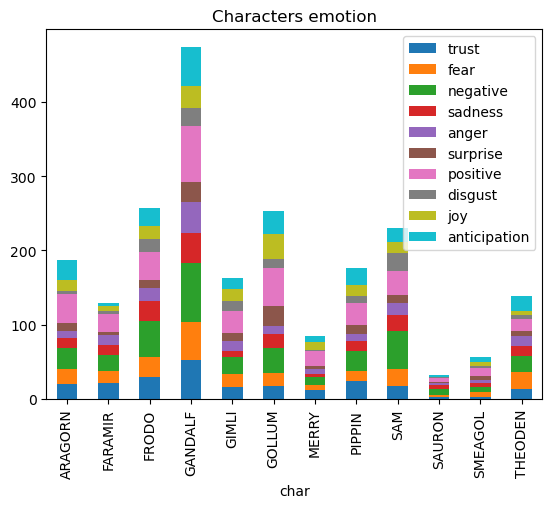

In [30]:

char_emot_filtered = char_emot[char_emot['char'].isin(imp_char)]

char_emot_filtered.plot(x='char', kind='bar', stacked=True,
        title='Characters emotion')
plt.show()

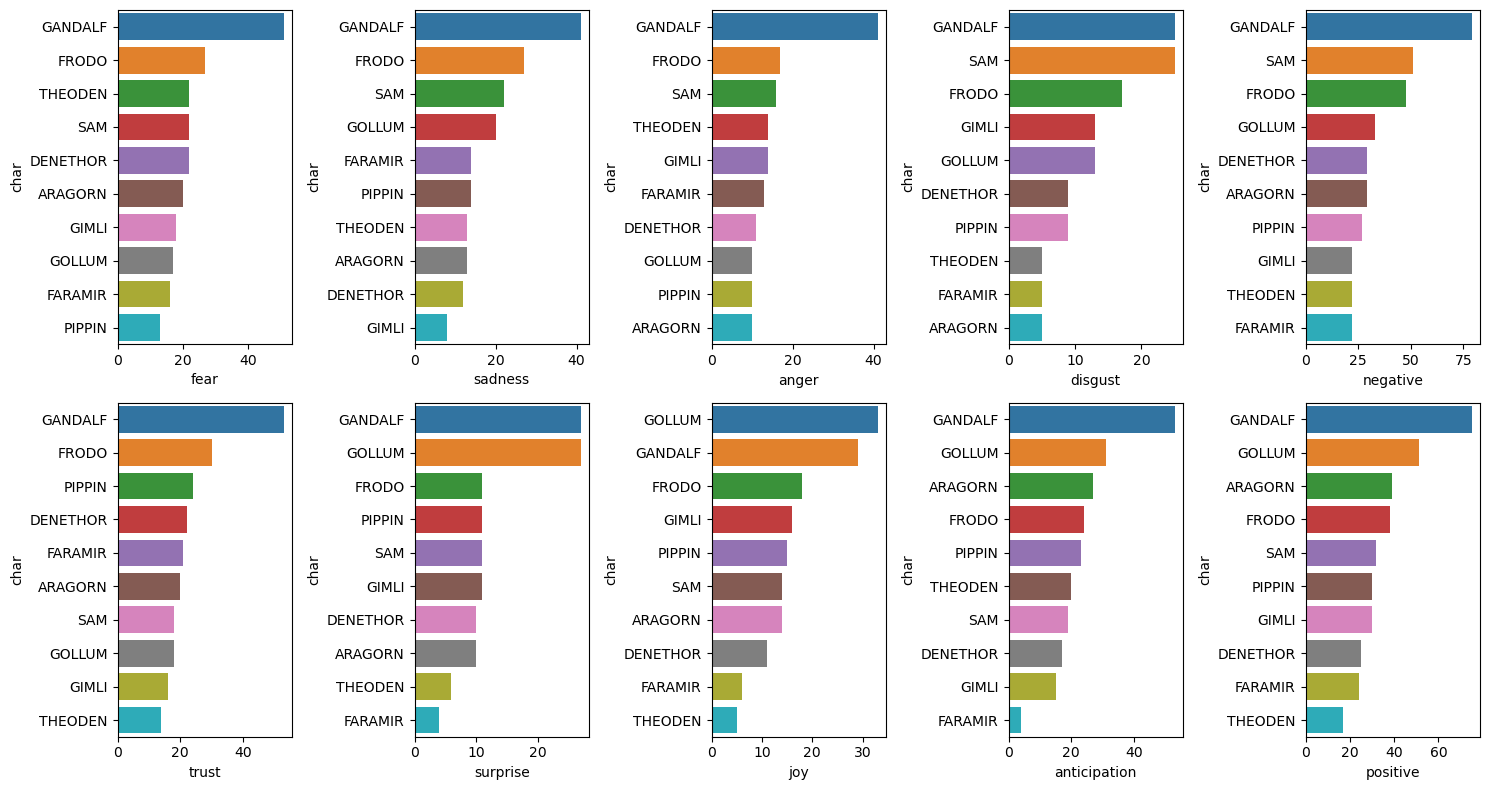

In [31]:
em_list = ['fear',  'sadness', 'anger', 'disgust', 'negative', 
           'trust', 'surprise',  'joy', 'anticipation', 'positive']

def char_emot_subplot(data, x):
    plt.figure(figsize = (15, 8))
    for i in range(1, len(x)+1):
        plt.subplot(2, 5, i)
        data = data.sort_values(by=x[i-1], ascending=False)[:10]
        sns.barplot(x=data[x[i-1]], y=data.char)
    plt.tight_layout()
    plt.show()

char_emot_subplot(char_emot, em_list)

### AVG TF-IDF Score for dialog

In [32]:
nan_indices = lotr_train.dialog.isna()
print(len(nan_indices))
lotr_train


1672


,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment,...,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation
0,ORCS,"Grond, Grond, Grond, Grond!",4,29,0,0,0,4,2,0.000,...,0,0,0,0,0,0,0,0,0,0
1,FRODO,Smeagol?,1,10,0,0,0,0,1,0.000,...,0,0,0,0,0,0,0,0,0,0
2,SAM,Look!The gate.It's opening!I can see a way down.,8,49,2,1,0,0,8,0.125,...,0,0,0,0,0,0,0,0,0,0
3,PIPPIN,"Well, that's good news.",4,24,0,0,1,0,4,0.500,...,1,0,0,0,0,1,1,0,1,1
4,PIPPIN,Frodo.,1,11,0,0,0,1,1,0.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,EOWYN,Your words are poison.,4,27,2,0,0,0,4,-0.125,...,0,1,2,1,2,0,0,1,0,0
1668,SARUMAN,A new power is rising.Its victory is at hand.,9,46,4,1,1,0,8,1.500,...,1,0,0,0,0,0,1,0,1,1
1669,ORC,"Come on then , come on!",6,31,2,2,0,0,6,0.375,...,0,0,0,0,0,0,0,0,0,0
1670,SAM,Mr. Frodo!,2,11,0,0,0,2,2,0.000,...,0,0,0,0,0,0,0,0,0,0


In [33]:
def tf(document: List[str], term: str) -> float:

    term_freq = FreqDist()
    for word in document:
        if word.lower() == term:
            term_freq[term] += 1
    
    termfreq = (term_freq[term])/len(document)
    return termfreq


def idf(documents: List[List[str]], term: str) -> float:

    doc_count = 0
    for doc in documents:
        if term in doc:
            doc_count +=1
    if doc_count == 0:
        return 0
    
    idf = np.log(len(documents)/(doc_count))
    return idf


def tf_idf(all_documents: List[List[str]], document: List[str], term: str) -> float:

    term_freq = tf(document, term)
    inverse_df = idf(all_documents, term)
    tf_idf = term_freq*inverse_df

    return tf_idf


def avg_tf_idf(data, preprocessed):
    dialog_avg_tfidf = []
    for dialog in preprocessed:
        score = 0
        for term in dialog:
            p = tf_idf(data.dialog, dialog, term)
            score += p
        avg_tfidf = score/(len(dialog)+1)
        dialog_avg_tfidf.append(avg_tfidf)
    data["avg_tf-idf"] = dialog_avg_tfidf
    return data

lotr_train = avg_tf_idf(lotr_train, preprocessed_train)
lotr_test = avg_tf_idf(lotr_test, preprocessed_test)
lotr_train.head()

,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment,...,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation,avg_tf-idf
0,ORCS,"Grond, Grond, Grond, Grond!",4,29,0,0,0,4,2,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
1,FRODO,Smeagol?,1,10,0,0,0,0,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
2,SAM,Look!The gate.It's opening!I can see a way down.,8,49,2,1,0,0,8,0.125,...,0,0,0,0,0,0,0,0,0,1.286746
3,PIPPIN,"Well, that's good news.",4,24,0,0,1,0,4,0.500,...,0,0,0,0,1,1,0,1,1,1.231094
4,PIPPIN,Frodo.,1,11,0,0,0,1,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000


## Character prediction
### Divide and conquer

In [177]:
# Creating a common label for the characters not of interest. 
# Aware that this will impact the model, unsure if it would be positive or negative


def common_label(data):
    mask = data["char"].isin(imp_char)
    data.loc[~ mask, "char"] = "Rest"
    mask2 = data['char'] == 'Rest'
    data = data[~mask2]
    return data

lotr_train = common_label(lotr_train)
lotr_test = common_label(lotr_test)


def x_y_split(data):
    y_data = data['char']
    x_data = data.drop(columns=['char', 'dialog'])
    return x_data, y_data

lotr_train_X, lotr_train_Y = x_y_split(lotr_train)
lotr_test_X, lotr_test_Y = x_y_split(lotr_test)

def char_2_num(y_data):
    encoder = LabelEncoder()
    y_data = y_data.values.reshape(-1, 1)
    encoded_data = encoder.fit_transform(y_data)
    names = list(encoder.inverse_transform(np.unique(encoded_data)))
    print(names)
    print(np.unique(encoded_data))
    return encoded_data, names

lotr_train_Y, names = char_2_num(lotr_train_Y)
lotr_test_Y = char_2_num(lotr_test_Y)[0]


['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'SAURON', 'SMEAGOL', 'THEODEN']
[ 0  1  2  3  4  5  6  7  8  9 10 11]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'SAURON', 'SMEAGOL', 'THEODEN']
[ 0  1  2  3  4  5  6  7  8  9 10 11]


### Naive Benchmark model


In [157]:
eval_methods = [ f1_score, precision_score, recall_score]

def naive_model(x_data, y_data):
    pred = np.random.randint(0, 12, size=len(x_data))
    print(classification_report(y_data, pred))
    print("Accuracy ", round(accuracy_score(y_data, pred), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(y_data, pred, average='weighted'), 4)) 
    return pred   

naive_predicitons = naive_model(lotr_test_X, lotr_test_Y)

              precision    recall  f1-score   support

           0       0.04      0.04      0.04        53
           1       0.00      0.00      0.00        14
           2       0.09      0.04      0.06        74
           3       0.12      0.07      0.08        76
           4       0.06      0.06      0.06        31
           5       0.11      0.16      0.13        32
           6       0.09      0.11      0.10        35
           7       0.15      0.14      0.14        44
           8       0.16      0.07      0.09        75
           9       0.00      0.00      0.00         2
          10       0.06      0.17      0.09        18
          11       0.10      0.11      0.10        36

    accuracy                           0.08       490
   macro avg       0.08      0.08      0.07       490
weighted avg       0.10      0.08      0.08       490

Accuracy  0.0796
f1_score 0.0833
precision_score 0.1009
recall_score 0.0796


### Random Forest Classifier


In [191]:

def optimize_model_parameters(X_train, y_train, model, param_grid, cv=5):
 
    rfc = model()

    grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Accuracy Score:", best_score)


    optimized = model(**best_params)
    optimized.fit(X_train, y_train)
    return optimized


param_grid = {
    'n_estimators': [15, 20, 25],
    'max_depth': [None, 3, 4, 5],
    'min_samples_split': [ 5, 10, 15],
    #'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# Optimize parameters
optimized_rf = optimize_model_parameters(lotr_train_X, lotr_train_Y, RFC, param_grid)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 15, 'n_estimators': 15}
Best Accuracy Score: 0.21874270656879352


In [150]:
optimized_rf

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200)

In [159]:
def evaluate_model(x_data, y_data, model):

    pred = model.predict(x_data)
    print(classification_report(y_data, pred))
    print("Accuracy ", round(accuracy_score(y_data, pred), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(y_data, pred, average='weighted'), 4)) 
    return pred  

rfc_predictions = evaluate_model(lotr_test_X, lotr_test_Y, optimized_rf) 

              precision    recall  f1-score   support

           0       0.11      0.13      0.12        53
           1       0.00      0.00      0.00        14
           2       0.19      0.28      0.22        74
           3       0.32      0.42      0.36        76
           4       0.11      0.06      0.08        31
           5       0.03      0.03      0.03        32
           6       0.09      0.09      0.09        35
           7       0.16      0.16      0.16        44
           8       0.20      0.17      0.18        75
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00        18
          11       0.08      0.03      0.04        36

    accuracy                           0.18       490
   macro avg       0.11      0.11      0.11       490
weighted avg       0.15      0.18      0.16       490

Accuracy  0.1776
f1_score 0.162
precision_score 0.1547
recall_score 0.1776


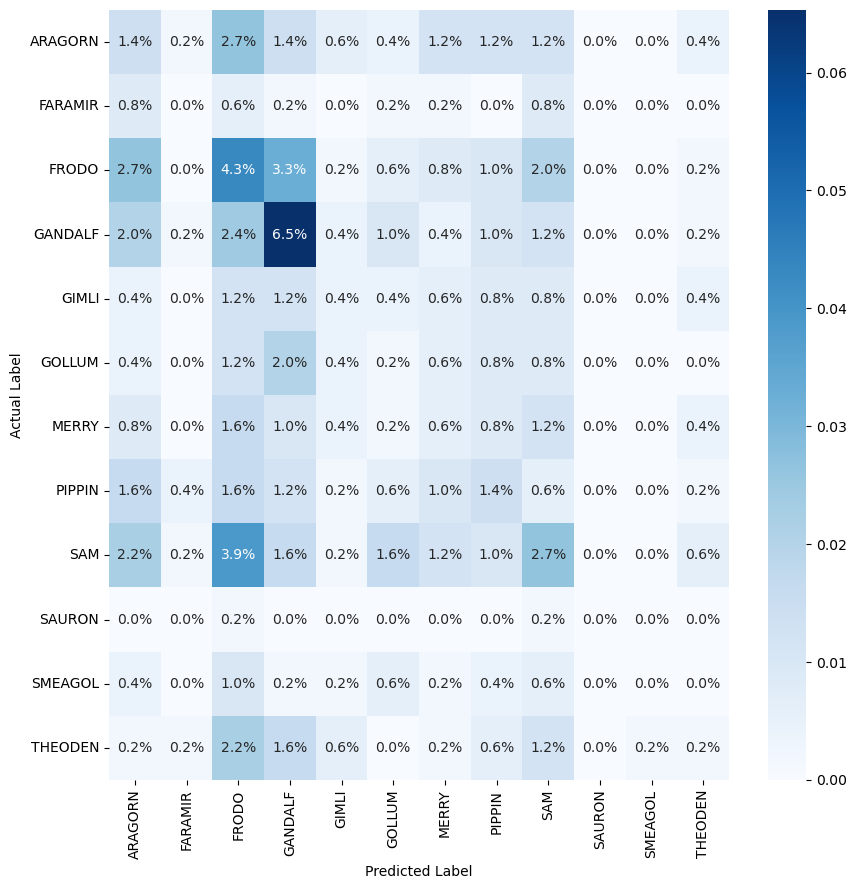

In [179]:

def conf_matrix(y, pred):
    cm = confusion_matrix(y, pred)
    # cm = np.hstack((cm,cm.sum(axis=1).reshape(-1,1)))
    # cm = np.vstack((cm,cm.sum(axis=0).reshape(1,-1)))
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cm/np.sum(cm), annot=True, 
                fmt='.1%', cmap='Blues', ax=ax, 
                xticklabels=names, yticklabels=names)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

conf_matrix(lotr_test_Y, rfc_predictions)

### SVM?

In [183]:

grid_params = [{ 'C':[0.5, 1, 3, 5], 
                'gamma':['scale',0.1, 0.01, 0.001], 
                'kernel':['rbf', 'linear', 'sigmoid', 'ploy'] }]


optimized_svc = optimize_model_parameters(lotr_test_X, lotr_test_Y, SVC, grid_params, cv=5)

Best Parameters: {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}
Best Accuracy Score: 0.19795918367346937


### ANN

In [204]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
import keras
from keras.models import Sequential
from keras.layers import Dense

def std_scale(data):
    return sc.fit_transform(data)

lotr_train_X = std_scale(lotr_train_X)
lotr_test_X = std_scale(lotr_test_X)

In [229]:
from keras.utils import to_categorical
from keras import backend as K

lotr_train_Y.reshape(-1,1)

# Assuming lotr_train_Y is your target array
lotr_train_Y_encoded = to_categorical(lotr_train_Y, num_classes=12)

AttributeError: module 'keras.src.backend' has no attribute 'is_tensor'

In [219]:
classifier = Sequential()

classifier.add(Dense(activation = 'relu', input_dim = 20, units=10))
classifier.add(Dense(units=10, activation = 'relu'))
classifier.add(Dense(units=12, activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.fit(lotr_train_X, lotr_train_Y, batch_size = 10, epochs = 100)


y_pred = classifier.predict(lotr_test_X)

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(lotr_test_Y, y_pred)
print(cm)
accuracy_score(lotr_test_Y, y_pred)

Epoch 1/100


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 12)